### Name: Shail Shah
### GitHub username: anonshail
### USC-ID: 9975958845

In [28]:
# All imports
import tensorflow as tf
import numpy as np
import pandas as pd
import os, random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pandas as pd
import shutil

# switching off logs
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

#### 1. Transfer Learning for Image Classification
#### It is highly recommended that you complete this project using Keras and Python.
#### 1.a. In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.
#### 1.b. Data Exploration and Pre-processing
#### 1.b.i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx
#### 1.b.ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.

In [29]:
# in case split folder exists
if os.path.exists('../data/split'):
    shutil.rmtree('../data/split')

# lists to hold image split data
trainImages, valImages, testImages  = [], [], []
classes = pd.read_excel('../data/Classes.xlsx')

# function to copy images to new split folder
def copySplit(parent, fileList, path):
    p1 = str(classes[classes['Folder Name ']==parent]['Class'].values.tolist()[0])
    os.makedirs(os.path.join('../data/split', path, p1), exist_ok=True)
    for file in fileList:
        p_a = os.path.join('../data/images', parent, file)
        p_b = os.path.join('../data/split', path, p1, file)
        shutil.copyfile(p_a, p_b)

for dirName in os.listdir('../data/images'):
    fileList = os.listdir(os.path.join('../data/images', dirName))
    random.shuffle(fileList)

    train_set = fileList[:int(np.ceil(len(fileList)*0.7))]
    trainImages.extend(train_set)
    copySplit(dirName, train_set, 'train')

    test_set = fileList[int(np.ceil(len(fileList)*0.7)):int(np.ceil(len(fileList)*0.85))] 
    testImages.extend(test_set)
    copySplit(dirName, test_set, 'test')

    val_set = fileList[int(np.ceil(len(fileList)*0.85)):]
    valImages.extend(val_set)
    copySplit(dirName, val_set, 'val')
        
print("\n\nTraining Set")
print(trainImages)
print("\n\nTesting Set")
print(testImages)
print("\n\nValidation Set")
print(valImages)




Training Set
['Artic_Tern_0093_141880.jpg', 'Artic_Tern_0119_142682.jpg', 'Artic_Tern_0023_140898.jpg', 'Artic_Tern_0026_141839.jpg', 'Artic_Tern_0046_140986.jpg', 'Artic_Tern_0012_143410.jpg', 'Artic_Tern_0047_143549.jpg', 'Artic_Tern_0037_141141.jpg', 'Artic_Tern_0142_142078.jpg', 'Artic_Tern_0085_142083.jpg', 'Artic_Tern_0122_142448.jpg', 'Artic_Tern_0124_142121.jpg', 'Artic_Tern_0034_142022.jpg', 'Artic_Tern_0107_141181.jpg', 'Artic_Tern_0014_141716.jpg', 'Artic_Tern_0089_141652.jpg', 'Artic_Tern_0065_141472.jpg', 'Artic_Tern_0127_142440.jpg', 'Artic_Tern_0030_141816.jpg', 'Artic_Tern_0059_141876.jpg', 'Artic_Tern_0060_141955.jpg', 'Artic_Tern_0092_141849.jpg', 'Artic_Tern_0032_141313.jpg', 'Artic_Tern_0090_143583.jpg', 'Artic_Tern_0099_141170.jpg', 'Artic_Tern_0133_141069.jpg', 'Artic_Tern_0019_141922.jpg', 'Artic_Tern_0035_143366.jpg', 'Artic_Tern_0063_142495.jpg', 'Artic_Tern_0044_142151.jpg', 'Artic_Tern_0021_143477.jpg', 'Artic_Tern_0015_141829.jpg', 'Artic_Tern_0027_141617.

#### 1.b.iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [30]:
imageResize = (224,224)
classes = pd.read_excel('../data/Classes.xlsx')

def returnData(dir):
    return tf.keras.utils.image_dataset_from_directory(
        os.path.join('../data/split/',dir),
        label_mode='categorical',
        color_mode="rgb",
        batch_size=8,
        image_size= imageResize,
        shuffle=True,
        seed=4629,
        interpolation="bilinear",
        crop_to_aspect_ratio=False,
        labels = 'inferred',
    )

trainData = returnData('train')
testData = returnData('test')
valData = returnData('val')

Found 827 files belonging to 20 classes.
Found 178 files belonging to 20 classes.
Found 171 files belonging to 20 classes.


#### 1.c. Transfer Learning
#### 1.c.i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.
#### 1.c.ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.
#### 1.c.iii Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [31]:
# dimensions
imageDimensions = (224, 224, 3)

# model and forming network for vgg16
vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top = True,
    weights = 'imagenet',
    input_shape = imageDimensions,
    pooling = None,
    classes = 1000,
    classifier_activation = 'softmax'
)

vgg16.trainable = False
ip = tf.keras.Input(shape=imageDimensions)
x = tf.keras.layers.RandomRotation(0.2)(ip)
x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
x = tf.keras.layers.RandomContrast(factor = 0.2, seed = 4629)(x)
x = tf.keras.layers.RandomCrop(height = imageDimensions[0], width = imageDimensions[1], seed = 4629)(x)
x = tf.keras.layers.RandomZoom(height_factor=0.2, width_factor = 0.2, seed = 4629)(x)
x = tf.keras.Model(inputs = vgg16.layers[0].input, outputs = vgg16.layers[-2].output, name = 'vgg16')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20, activation = "relu")(x)
output = tf.keras.layers.Softmax()(x)
vgg16Model = tf.keras.Model(inputs=ip, outputs=output)

# displaying vgg16 model summary
vgg16Model.summary()

##############################################################################################################

# model and forming network for EfficientNetB0
efficientNet = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top = True,
    weights = 'imagenet',
    input_shape = imageDimensions,
    pooling = None,
    classes = 1000,
    classifier_activation = 'softmax',
)

efficientNet.trainable = False
ip = tf.keras.Input(shape=imageDimensions)
x = tf.keras.layers.RandomRotation(0.2)(ip)
x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
x = tf.keras.layers.RandomContrast(factor = 0.2, seed = 4629)(x)
x = tf.keras.layers.RandomCrop(height = imageDimensions[0], width = imageDimensions[1], seed = 4629)(x)
x = tf.keras.layers.RandomZoom(height_factor=0.2, width_factor = 0.2, seed = 4629)(x)
x = tf.keras.Model(inputs = efficientNet.layers[0].input, outputs = efficientNet.layers[-2].output, name = 'efficientNet')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20, activation = "relu")(x)
output = tf.keras.layers.Softmax()(x)
efficientNetModel = tf.keras.Model(inputs=ip, outputs=output)

# displaying efficientNet model summary
efficientNetModel.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 random_rotation_10 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_flip_10 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_contrast_10 (RandomC  (None, 224, 224, 3)      0         
 ontrast)                                                        
                                                                 
 random_crop_10 (RandomCrop)  (None, 224, 224, 3)      0         
                                                                 
 random_zoom_10 (RandomZoom)  (None, 224, 224, 3)      0  

#### 1.c.iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [32]:
noOfEpochs = 100

def getCallbacksFor(modelDir):
    earlyStoppingCb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose = 1)
    modelCheckpointCb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('../data/cps', modelDir, 'checkpoint.h5py'),
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose = 1
    )
    return [earlyStoppingCb, modelCheckpointCb]

def calculatePrecision(y_true, y_pred):
    truePos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predPos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return truePos / (predPos + K.epsilon())

def calculateRecall(y_true, y_pred):
    truePos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predPos = K.sum(K.round(K.clip(y_true, 0, 1)))
    return truePos / (predPos + K.epsilon())

def calculateF1(y_true, y_pred):
    precision = calculatePrecision(y_true, y_pred)
    recall = calculateRecall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

vgg16Model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy", calculatePrecision, calculateRecall, calculateF1])
vggHistory = vgg16Model.fit(trainData, epochs=noOfEpochs, validation_data=valData, callbacks = getCallbacksFor('vgg/'))

efficientNetModel.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy", calculatePrecision, calculateRecall, calculateF1])
efficientHistory = efficientNetModel.fit(trainData, epochs=noOfEpochs, validation_data=valData, callbacks = getCallbacksFor('efficient/'))

Epoch 1/100


2022-12-11 17:23:46.268908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_10/random_crop_10/loop_body/cond/pfor/cond/branch_executed/_731


104/104 [==============================] - ETA: 0s - loss: 2.4284 - accuracy: 0.3241 - calculatePrecision: 0.4373 - calculateRecall: 0.2232 - calculateF1: 0.2838
Epoch 1: val_accuracy improved from -inf to 0.61988, saving model to ../data/cps/vgg/checkpoint.h5py
104/104 [==============================] - 115s 1s/step - loss: 2.4284 - accuracy: 0.3241 - calculatePrecision: 0.4373 - calculateRecall: 0.2232 - calculateF1: 0.2838 - val_loss: 1.2772 - val_accuracy: 0.6199 - val_calculatePrecision: 0.7199 - val_calculateRecall: 0.5663 - val_calculateF1: 0.6285
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 1.5582 - accuracy: 0.5647 - calculatePrecision: 0.6914 - calculateRecall: 0.5036 - calculateF1: 0.5724
Epoch 2: val_accuracy improved from 0.61988 to 0.73099, saving model to ../data/cps/vgg/checkpoint.h5py
104/104 [==============================] - 117s 1s/step - loss: 1.5582 - accuracy: 0.5647 - calculatePrecision: 0.6914 - calculateRecall: 0.5036 - calculateF1: 0

104/104 [==============================] - 120s 1s/step - loss: 0.6494 - accuracy: 0.8319 - calculatePrecision: 0.8580 - calculateRecall: 0.8117 - calculateF1: 0.8322 - val_loss: 1.7232 - val_accuracy: 0.7135 - val_calculatePrecision: 0.7251 - val_calculateRecall: 0.7121 - val_calculateF1: 0.7182
Epoch 17/100
104/104 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.8053 - calculatePrecision: 0.8402 - calculateRecall: 0.7833 - calculateF1: 0.8089
Epoch 17: val_accuracy did not improve from 0.75439
104/104 [==============================] - 120s 1s/step - loss: 0.6666 - accuracy: 0.8053 - calculatePrecision: 0.8402 - calculateRecall: 0.7833 - calculateF1: 0.8089 - val_loss: 1.7060 - val_accuracy: 0.7135 - val_calculatePrecision: 0.7256 - val_calculateRecall: 0.7159 - val_calculateF1: 0.7205
Epoch 18/100
104/104 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.8235 - calculatePrecision: 0.8499 - calculateRecall: 0.8001 - calculateF1: 0.8215
Ep

104/104 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.8767 - calculatePrecision: 0.8927 - calculateRecall: 0.8726 - calculateF1: 0.8820
Epoch 32: val_accuracy did not improve from 0.75439
104/104 [==============================] - 108s 1s/step - loss: 0.4386 - accuracy: 0.8767 - calculatePrecision: 0.8927 - calculateRecall: 0.8726 - calculateF1: 0.8820 - val_loss: 1.8309 - val_accuracy: 0.7427 - val_calculatePrecision: 0.7581 - val_calculateRecall: 0.7500 - val_calculateF1: 0.7538
Epoch 33/100
104/104 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.8597 - calculatePrecision: 0.8728 - calculateRecall: 0.8510 - calculateF1: 0.8610
Epoch 33: val_accuracy did not improve from 0.75439
104/104 [==============================] - 109s 1s/step - loss: 0.5460 - accuracy: 0.8597 - calculatePrecision: 0.8728 - calculateRecall: 0.8510 - calculateF1: 0.8610 - val_loss: 1.9491 - val_accuracy: 0.7368 - val_calculatePrecision: 0.7470 - val_calculateReca

Epoch 48/100
104/104 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.9021 - calculatePrecision: 0.9116 - calculateRecall: 0.8954 - calculateF1: 0.9029
Epoch 48: val_accuracy did not improve from 0.77193
104/104 [==============================] - 109s 1s/step - loss: 0.3806 - accuracy: 0.9021 - calculatePrecision: 0.9116 - calculateRecall: 0.8954 - calculateF1: 0.9029 - val_loss: 2.1409 - val_accuracy: 0.7310 - val_calculatePrecision: 0.7119 - val_calculateRecall: 0.7045 - val_calculateF1: 0.7080
Epoch 49/100
104/104 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8912 - calculatePrecision: 0.9080 - calculateRecall: 0.8858 - calculateF1: 0.8960
Epoch 49: val_accuracy did not improve from 0.77193
104/104 [==============================] - 108s 1s/step - loss: 0.3957 - accuracy: 0.8912 - calculatePrecision: 0.9080 - calculateRecall: 0.8858 - calculateF1: 0.8960 - val_loss: 2.3120 - val_accuracy: 0.7368 - val_calculatePrecision: 0.7430 - val_

Epoch 64/100
104/104 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8815 - calculatePrecision: 0.8968 - calculateRecall: 0.8786 - calculateF1: 0.8871
Epoch 64: val_accuracy did not improve from 0.77778
104/104 [==============================] - 167s 2s/step - loss: 0.4297 - accuracy: 0.8815 - calculatePrecision: 0.8968 - calculateRecall: 0.8786 - calculateF1: 0.8871 - val_loss: 2.4539 - val_accuracy: 0.7135 - val_calculatePrecision: 0.7321 - val_calculateRecall: 0.7064 - val_calculateF1: 0.7174
Epoch 65/100
104/104 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.8912 - calculatePrecision: 0.9007 - calculateRecall: 0.8814 - calculateF1: 0.8903
Epoch 65: val_accuracy did not improve from 0.77778
104/104 [==============================] - 177s 2s/step - loss: 0.4112 - accuracy: 0.8912 - calculatePrecision: 0.9007 - calculateRecall: 0.8814 - calculateF1: 0.8903 - val_loss: 2.3039 - val_accuracy: 0.7018 - val_calculatePrecision: 0.7040 - val_

Epoch 80/100
104/104 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.9154 - calculatePrecision: 0.9286 - calculateRecall: 0.9054 - calculateF1: 0.9160
Epoch 80: val_accuracy did not improve from 0.77778
104/104 [==============================] - 122s 1s/step - loss: 0.3348 - accuracy: 0.9154 - calculatePrecision: 0.9286 - calculateRecall: 0.9054 - calculateF1: 0.9160 - val_loss: 2.5774 - val_accuracy: 0.7251 - val_calculatePrecision: 0.7332 - val_calculateRecall: 0.7178 - val_calculateF1: 0.7246
Epoch 81/100
104/104 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.8827 - calculatePrecision: 0.8902 - calculateRecall: 0.8786 - calculateF1: 0.8840
Epoch 81: val_accuracy did not improve from 0.77778
104/104 [==============================] - 121s 1s/step - loss: 0.5135 - accuracy: 0.8827 - calculatePrecision: 0.8902 - calculateRecall: 0.8786 - calculateF1: 0.8840 - val_loss: 2.7785 - val_accuracy: 0.7193 - val_calculatePrecision: 0.7321 - val_

Epoch 96/100
104/104 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.9166 - calculatePrecision: 0.9261 - calculateRecall: 0.9115 - calculateF1: 0.9182
Epoch 96: val_accuracy did not improve from 0.77778
104/104 [==============================] - 151s 1s/step - loss: 0.3411 - accuracy: 0.9166 - calculatePrecision: 0.9261 - calculateRecall: 0.9115 - calculateF1: 0.9182 - val_loss: 2.8798 - val_accuracy: 0.6784 - val_calculatePrecision: 0.6742 - val_calculateRecall: 0.6686 - val_calculateF1: 0.6712
Epoch 97/100
104/104 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.9057 - calculatePrecision: 0.9152 - calculateRecall: 0.9026 - calculateF1: 0.9085
Epoch 97: val_accuracy did not improve from 0.77778
104/104 [==============================] - 172s 2s/step - loss: 0.3931 - accuracy: 0.9057 - calculatePrecision: 0.9152 - calculateRecall: 0.9026 - calculateF1: 0.9085 - val_loss: 3.1407 - val_accuracy: 0.7135 - val_calculatePrecision: 0.7275 - val_

2022-12-11 20:51:08.316749: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_11/random_crop_11/loop_body/cond/pfor/cond/branch_executed/_731


104/104 [==============================] - ETA: 0s - loss: 2.5465 - accuracy: 0.2757 - calculatePrecision: 0.4037 - calculateRecall: 0.1382 - calculateF1: 0.1958
Epoch 1: val_accuracy improved from -inf to 0.56725, saving model to ../data/cps/efficient/checkpoint.h5py
104/104 [==============================] - 27s 191ms/step - loss: 2.5465 - accuracy: 0.2757 - calculatePrecision: 0.4037 - calculateRecall: 0.1382 - calculateF1: 0.1958 - val_loss: 1.8167 - val_accuracy: 0.5673 - val_calculatePrecision: 0.5455 - val_calculateRecall: 0.0852 - val_calculateF1: 0.1455
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 1.2534 - accuracy: 0.6215 - calculatePrecision: 0.7838 - calculateRecall: 0.4844 - calculateF1: 0.5863
Epoch 2: val_accuracy improved from 0.56725 to 0.66082, saving model to ../data/cps/efficient/checkpoint.h5py
104/104 [==============================] - 19s 182ms/step - loss: 1.2534 - accuracy: 0.6215 - calculatePrecision: 0.7838 - calculateRecall: 0.4844 

Epoch 16/100
104/104 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.8682 - calculatePrecision: 0.9084 - calculateRecall: 0.8490 - calculateF1: 0.8753
Epoch 16: val_accuracy improved from 0.80117 to 0.80702, saving model to ../data/cps/efficient/checkpoint.h5py
104/104 [==============================] - 19s 183ms/step - loss: 0.3479 - accuracy: 0.8682 - calculatePrecision: 0.9084 - calculateRecall: 0.8490 - calculateF1: 0.8753 - val_loss: 0.5874 - val_accuracy: 0.8070 - val_calculatePrecision: 0.8506 - val_calculateRecall: 0.7860 - val_calculateF1: 0.8158
Epoch 17/100
104/104 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8900 - calculatePrecision: 0.9053 - calculateRecall: 0.8638 - calculateF1: 0.8822
Epoch 17: val_accuracy did not improve from 0.80702
104/104 [==============================] - 19s 183ms/step - loss: 0.3410 - accuracy: 0.8900 - calculatePrecision: 0.9053 - calculateRecall: 0.8638 - calculateF1: 0.8822 - val_loss: 0.6024

104/104 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.9069 - calculatePrecision: 0.9220 - calculateRecall: 0.8890 - calculateF1: 0.9042
Epoch 31: val_accuracy did not improve from 0.81871
104/104 [==============================] - 23s 223ms/step - loss: 0.2928 - accuracy: 0.9069 - calculatePrecision: 0.9220 - calculateRecall: 0.8890 - calculateF1: 0.9042 - val_loss: 0.6380 - val_accuracy: 0.7895 - val_calculatePrecision: 0.8103 - val_calculateRecall: 0.7633 - val_calculateF1: 0.7848
Epoch 32/100
104/104 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9190 - calculatePrecision: 0.9341 - calculateRecall: 0.9087 - calculateF1: 0.9204
Epoch 32: val_accuracy did not improve from 0.81871
104/104 [==============================] - 22s 215ms/step - loss: 0.2391 - accuracy: 0.9190 - calculatePrecision: 0.9341 - calculateRecall: 0.9087 - calculateF1: 0.9204 - val_loss: 0.6359 - val_accuracy: 0.7836 - val_calculatePrecision: 0.8428 - val_calculate

104/104 [==============================] - 20s 193ms/step - loss: 0.2257 - accuracy: 0.9214 - calculatePrecision: 0.9385 - calculateRecall: 0.9119 - calculateF1: 0.9241 - val_loss: 0.7155 - val_accuracy: 0.8246 - val_calculatePrecision: 0.8241 - val_calculateRecall: 0.7955 - val_calculateF1: 0.8083
Epoch 47/100
104/104 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9141 - calculatePrecision: 0.9361 - calculateRecall: 0.9111 - calculateF1: 0.9226
Epoch 47: val_accuracy did not improve from 0.84211
104/104 [==============================] - 20s 188ms/step - loss: 0.2373 - accuracy: 0.9141 - calculatePrecision: 0.9361 - calculateRecall: 0.9111 - calculateF1: 0.9226 - val_loss: 0.6283 - val_accuracy: 0.8246 - val_calculatePrecision: 0.8425 - val_calculateRecall: 0.8239 - val_calculateF1: 0.8326
Epoch 48/100
104/104 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9287 - calculatePrecision: 0.9417 - calculateRecall: 0.9207 - calculateF1: 0.930

Epoch 62/100
104/104 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.9166 - calculatePrecision: 0.9257 - calculateRecall: 0.9111 - calculateF1: 0.9179
Epoch 62: val_accuracy did not improve from 0.85380
104/104 [==============================] - 23s 223ms/step - loss: 0.2634 - accuracy: 0.9166 - calculatePrecision: 0.9257 - calculateRecall: 0.9111 - calculateF1: 0.9179 - val_loss: 0.6710 - val_accuracy: 0.8129 - val_calculatePrecision: 0.8266 - val_calculateRecall: 0.7917 - val_calculateF1: 0.8080
Epoch 63/100
104/104 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9432 - calculatePrecision: 0.9538 - calculateRecall: 0.9363 - calculateF1: 0.9445
Epoch 63: val_accuracy did not improve from 0.85380
104/104 [==============================] - 23s 222ms/step - loss: 0.1669 - accuracy: 0.9432 - calculatePrecision: 0.9538 - calculateRecall: 0.9363 - calculateF1: 0.9445 - val_loss: 0.6245 - val_accuracy: 0.8187 - val_calculatePrecision: 0.8290 - 

Epoch 78/100
104/104 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9323 - calculatePrecision: 0.9384 - calculateRecall: 0.9303 - calculateF1: 0.9341
Epoch 78: val_accuracy did not improve from 0.85965
104/104 [==============================] - 22s 216ms/step - loss: 0.2341 - accuracy: 0.9323 - calculatePrecision: 0.9384 - calculateRecall: 0.9303 - calculateF1: 0.9341 - val_loss: 0.7058 - val_accuracy: 0.8129 - val_calculatePrecision: 0.8369 - val_calculateRecall: 0.7955 - val_calculateF1: 0.8143
Epoch 79/100
104/104 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9480 - calculatePrecision: 0.9554 - calculateRecall: 0.9403 - calculateF1: 0.9471
Epoch 79: val_accuracy did not improve from 0.85965
104/104 [==============================] - 23s 218ms/step - loss: 0.1605 - accuracy: 0.9480 - calculatePrecision: 0.9554 - calculateRecall: 0.9403 - calculateF1: 0.9471 - val_loss: 0.7183 - val_accuracy: 0.8187 - val_calculatePrecision: 0.8228 - 

Epoch 94/100
104/104 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9407 - calculatePrecision: 0.9458 - calculateRecall: 0.9367 - calculateF1: 0.9409
Epoch 94: val_accuracy did not improve from 0.85965
104/104 [==============================] - 22s 213ms/step - loss: 0.1855 - accuracy: 0.9407 - calculatePrecision: 0.9458 - calculateRecall: 0.9367 - calculateF1: 0.9409 - val_loss: 0.7901 - val_accuracy: 0.8070 - val_calculatePrecision: 0.8350 - val_calculateRecall: 0.8011 - val_calculateF1: 0.8166
Epoch 95/100
104/104 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9432 - calculatePrecision: 0.9449 - calculateRecall: 0.9391 - calculateF1: 0.9418
Epoch 95: val_accuracy did not improve from 0.85965
104/104 [==============================] - 23s 217ms/step - loss: 0.1909 - accuracy: 0.9432 - calculatePrecision: 0.9449 - calculateRecall: 0.9391 - calculateF1: 0.9418 - val_loss: 0.7721 - val_accuracy: 0.8070 - val_calculatePrecision: 0.8320 - 

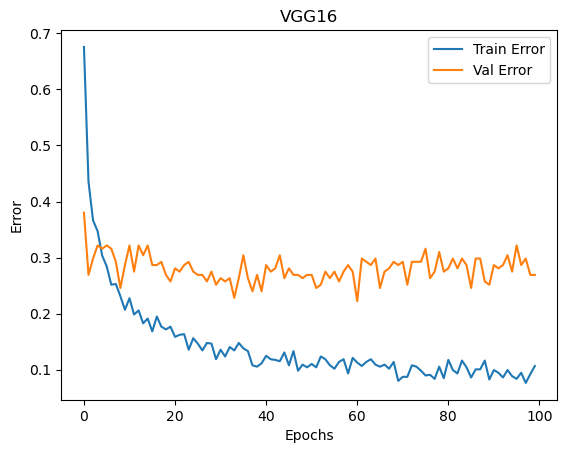

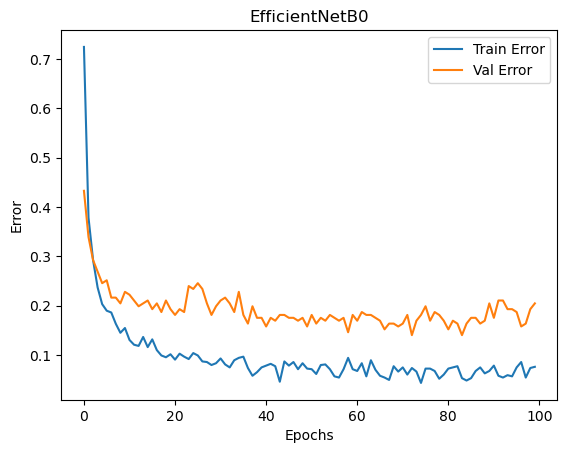

In [34]:
vgg16Model.load_weights('../data/cps/vgg/checkpoint.h5py')
efficientNetModel.load_weights('../data/cps/efficient/checkpoint.h5py')

# plotting epoch vs error graph for vgg16
vggEpoch = vggHistory.epoch
vggTrainError = [1 - accuracy for accuracy in vggHistory.history['accuracy']]
vggValError = [1-accuracy for accuracy in vggHistory.history['val_accuracy']]

plt.plot(vggEpoch, vggTrainError, label = 'Train Error')
plt.plot(vggEpoch, vggValError, label = 'Val Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('VGG16')
plt.legend()
plt.show()

# plotting epoch vs error graph for EfficientNetB0
efficientEpoch = efficientHistory.epoch
efficientTrainError = [1-accuracy for accuracy in efficientHistory.history['accuracy']]
efficientValError = [1-accuracy for accuracy in efficientHistory.history['val_accuracy']]

plt.plot(efficientEpoch, efficientTrainError, label = 'Train Error')
plt.plot(efficientEpoch, efficientValError, label = 'Val Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('EfficientNetB0')
plt.legend()
plt.show()

#### 1.c.v. Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.

In [35]:
vggPredTrain = ['VGG-train']
vggPredTrain.extend(vgg16Model.evaluate(trainData))

vggPredTest = ['VGG-test']
vggPredTest.extend(vgg16Model.evaluate(testData))

effPredTrain = ['Efficienct-train']
effPredTrain.extend(efficientNetModel.evaluate(trainData))

effPredTest = ['Efficient-test']
effPredTest.extend(efficientNetModel.evaluate(testData))

pred = [vggPredTrain, effPredTrain, vggPredTest, effPredTest]
x = pd.DataFrame(
  pred, 
  columns = ['Data Set', 'Categorical Crossentropy Loss', 'Accuracy','Precision','Recall','F1 Score']
)
x

23/23 [==============================] - 3s 122ms/step - loss: 0.6166 - accuracy: 0.8202 - calculatePrecision: 0.8649 - calculateRecall: 0.8207 - calculateF1: 0.8413


,Data Set,Categorical Crossentropy Loss,Accuracy,Precision,Recall,F1 Score
0,VGG-train,0.110992,0.972189,0.972356,0.968750,0.970433
1,Efficienct-train,0.223842,0.912938,0.934066,0.902644,0.917216
2,VGG-test,2.492230,0.691011,0.700311,0.695652,0.697826
3,Efficient-test,0.616588,0.820225,0.864907,0.820652,0.841304


#### References
1. https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model